In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import shutil
import models as m
import math


In [2]:
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA runtime:", torch.version.cuda)
    print("cuDNN:", torch.backends.cudnn.version())
    print("GPU:", torch.cuda.get_device_name(0))
    print("Capability:", torch.cuda.get_device_capability(0))


Torch: 2.6.0+cu124
CUDA available: True
CUDA runtime: 12.4
cuDNN: 90100
GPU: Tesla P100-PCIE-16GB
Capability: (6, 0)


----
#### CONFIG Sauvegarde

In [3]:
# CONFIG SAUVEGARDE 
SAVE = True  

def get_next_run_id(exp_dir: str) -> str:
    existing = [
        d for d in os.listdir(exp_dir)
        if d.isdigit() and len(d) == 3
    ] 
    if not existing:
        return "001"
    return f"{int(max(existing))+1:03d}"

BASE_PATH = os.getcwd()
RUNS_ROOT = os.path.join(BASE_PATH, "runs")
os.makedirs(RUNS_ROOT, exist_ok=True)

EXP_NAME = "baseline"
EXP_DIR = os.path.join(RUNS_ROOT, EXP_NAME)
os.makedirs(EXP_DIR, exist_ok=True)

RUN_ID = get_next_run_id(EXP_DIR)
RUN_DIR = os.path.join(EXP_DIR, RUN_ID)  # <- fix ici
print(RUN_ID)

if SAVE:
    os.makedirs(RUN_DIR, exist_ok=True)
    FIG_DIR = os.path.join(RUN_DIR, "figures")
    WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")
    LOGS_DIR = os.path.join(RUN_DIR, "logs")
    VIDEO_DIR = os.path.join(RUN_DIR,'videos')
    OUTDIR = os.path.join(VIDEO_DIR,'out/')
    os.makedirs(FIG_DIR, exist_ok=True)
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    os.makedirs(LOGS_DIR, exist_ok=True)
    os.makedirs(VIDEO_DIR,exist_ok=True)
else:
    FIG_DIR = WEIGHTS_DIR = LOGS_DIR = VIDEO_DIR = None



001


------
### Device

In [4]:
torch.set_default_dtype(torch.float32)

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor

elif torch.cuda.is_available():
    device = torch.device('cuda:0')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
    
def t(x):
    # j'avais des problèmes de type avec les long 
    return torch.as_tensor(x, dtype=torch.get_default_dtype()).to(device)

print(device)


cuda:0


------

## Dataset 

In [5]:

transform = transforms.Compose([
    transforms.ToTensor(),                          # [0,1]
    transforms.Lambda(lambda x: x * 2.0 - 1.0)      # [-1,1]
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])
tensor(-1.) tensor(1.)


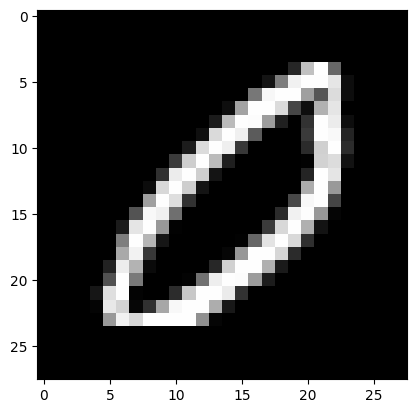

Label: 0


In [6]:

dataloader = DataLoader(training_data,batch_size=128,shuffle=True)
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
print(img.min(),img.max())
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

------
###Loss

In [7]:
def LossNCSN(model, x, sigmas, eps_trainning: bool = False):
    """
    x:      (B, C, H, W) ou (B, D)
    sigmas: (n_sigmas,) tensor
    modèle:
        f(x_noisy, sigma) -> même shape que x
        sigma: (B,), (B,1) ou (B,1,1,1)
    """
    B = x.size(0)
    device = x.device

    # 1) sample un sigma par sample
    idx = torch.randint(0, len(sigmas), (B,), device=device)
    sigma_vals = sigmas[idx]  # (B,)

    # 2) sigma pour le bruit: broadcast à la shape de x
    sigma_noise = sigma_vals.view(B, 1)
    while sigma_noise.dim() < x.dim():
        sigma_noise = sigma_noise.unsqueeze(-1)  # -> (B,1,1,1) si image

    # 3) sigma pour le modèle: on lui passe sigma_noise tel quel
    sigma_model = sigma_noise

    # 4) bruitage
    eps = torch.randn_like(x)
    x_noisy = x + sigma_noise * eps

    # 5) epsilon-training
    if eps_trainning:
        eps_hat = model(x_noisy, sigma_model)
        loss = ((eps_hat + eps) ** 2).mean()
        return loss

    # 6) score-training
    s_hat = model(x_noisy, sigma_model)
    target = -eps / (sigma_noise + 1e-8)
    lambda_i = sigma_noise**2              # (B,1)
    loss_i = ((s_hat - target)**2).sum(dim=-1, keepdim=True)  # (B,1)
    loss = (lambda_i * loss_i).mean()
    return loss


In [8]:
def construct_noise_linspace(min,max,L):
    return torch.linspace(min,max,L).flip(0).to(device)

def construct_noise_logspace(sigma_min,sigma_max,L):
    return torch.logspace(
        torch.log10(t(sigma_min)),
        torch.log10(t(sigma_max)),L
    ).flip(0).to(device)

# pas de gradient ici pour ALD 
def make_score_from_model(model, sigma_scalar,eps_loss = False):
    sigma_scalar = float(sigma_scalar)
    @torch.no_grad()
    def score(x):
        # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma)
    @torch.no_grad()
    def score_eps(x):
       # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma) /sigma
    if eps_loss : 
        return score_eps
    else : 
        return score    

In [9]:
batch_size = 128
N_train = 10000
EVAL_EVERY = 700
lr = 1e-3

# Sigma config
SIGMA_MIN = 1e-1        
SIGMA_MAX = 1
N_SIGMAS = 10
SIGMA_SCHEDULE = "lin"    # ou "lin"
EPS_TRAINNING = False    


if SIGMA_SCHEDULE == "lin":
    sigmas = construct_noise_logspace(SIGMA_MIN, SIGMA_MAX, N_SIGMAS)
elif SIGMA_SCHEDULE == "lin":
    sigmas = construct_noise_linspace(SIGMA_MIN, SIGMA_MAX, N_SIGMAS)
else:
    raise ValueError(f"Unknown SIGMA_SCHEDULE: {SIGMA_SCHEDULE}")

in_ch = 1  
base_ch = 16
channel_mults = (1, 2,4) 
SIGMA_EMB_DIM = 16

model = m.SmallUNetSigma(
    in_ch=in_ch,
    base_ch=base_ch,
    channel_mults=channel_mults,  
    emb_dim=SIGMA_EMB_DIM,
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# SAUVEGARDE des HYPERPARAMS 
if SAVE:
    hparams = {
    "batch_size": batch_size,
    "N_train": N_train,
    "EVAL_EVERY": EVAL_EVERY,
    "lr": lr,
    "EPS_TRAINNING": EPS_TRAINNING,
    "sigma": {
        "schedule": SIGMA_SCHEDULE,
        "min": SIGMA_MIN,
        "max": SIGMA_MAX,
        "n_sigmas": N_SIGMAS,
        "values": [float(s) for s in sigmas],
    },
    
    "device": str(device),
    "model": {
        "in_channel" : in_ch,
        "base_ch" : base_ch,
        "channel_mults" : channel_mults,
        "sigma_emb_dim": SIGMA_EMB_DIM,
    },
    }


    with open(os.path.join(LOGS_DIR, "hparams.json"), "w") as f:
        json.dump(hparams, f, indent=4)


In [10]:
total = sum(p.numel() for p in model.parameters())
print(f"{total/1e6:.2f} M params")

0.30 M params


In [11]:
model.train()

L = []
eval_steps = []

for step in range(N_train):
    x,_ = next(iter(dataloader))
    x = x.to(device)
    optimizer.zero_grad()

    loss = LossNCSN(model, x, sigmas, EPS_TRAINNING)
    loss.backward()
    optimizer.step()
    L.append(loss.item())
    
    if (step + 1) % EVAL_EVERY == 0 or step==N_train-1:
        model.eval()
        eval_steps.append(step+1)
        print(f"[{step+1}/{N_train}] train loss (last {EVAL_EVERY}) = {np.mean(L[-EVAL_EVERY:]):.4f}")
        # saving des poids en cours de route
        if SAVE : 
            torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "model.pt"))
        model.train()

# SAUVEGARDE METRICS BRUTES 
if SAVE:
    np.save(os.path.join(LOGS_DIR, "train_loss.npy"), np.array(L))
    np.save(os.path.join(LOGS_DIR, "steps_eval.npy"), np.array(eval_steps))
    # Poids du modèle
    torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "model.pt"))


[700/10000] train loss (last 700) = 11.7119
[1400/10000] train loss (last 700) = 5.5158
[2100/10000] train loss (last 700) = 3.8269
[2800/10000] train loss (last 700) = 3.0843
[3500/10000] train loss (last 700) = 2.6947
[4200/10000] train loss (last 700) = 2.4823
[4900/10000] train loss (last 700) = 2.3601
[5600/10000] train loss (last 700) = 2.2807
[6300/10000] train loss (last 700) = 2.2215
[7000/10000] train loss (last 700) = 2.1819
[7700/10000] train loss (last 700) = 2.1546
[8400/10000] train loss (last 700) = 2.1375
[9100/10000] train loss (last 700) = 2.1066
[9800/10000] train loss (last 700) = 2.0885
[10000/10000] train loss (last 700) = 2.0837


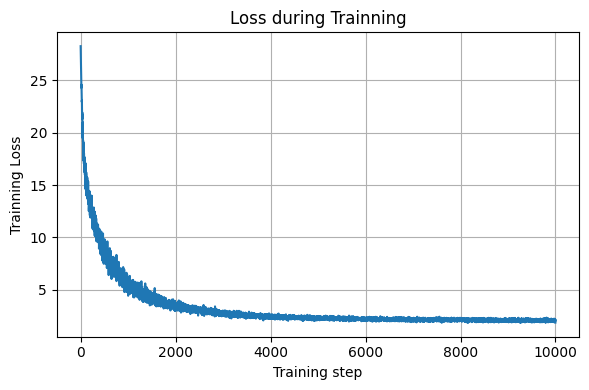

In [12]:
plt.figure(figsize=(6,4))
plt.title('Loss during Trainning')
plt.plot(L)
plt.xlabel("Training step")
plt.ylabel("Trainning Loss")
plt.grid(True)
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "train_loss.png"), dpi=200)
plt.show()


In [13]:
model.eval()
estimated_distribution_scores = [make_score_from_model(model,noise,EPS_TRAINNING) for noise in list(sigmas)]

In [15]:
NUM_BATCH = 10
N = []

data_iter = iter(dataloader)

for idx in range(N_SIGMAS):
    norm = 0.0
    s = sigmas[idx]              # scalaire, device déjà correct

    for _ in range(NUM_BATCH):
        
        x, _ = next(data_iter)

        x = x.to(device)
        B = x.size(0)

        # sigma de shape (B, 1, 1, 1) avec valeur s
        sigma = s.expand(B, 1)
        while sigma.dim() < x.dim():
            sigma = sigma.unsqueeze(-1)   # -> (B,1,1,1)

        # bruitage
        eps = torch.randn_like(x)
        x_noisy = x + sigma * eps

        # IMPORTANT : passer sigma (batch), pas le scalaire s
        score = model(x_noisy, sigma)

        
        # (on écrase toutes les dims sauf batch)
        score_sq = (score ** 2).view(B, -1).sum(dim=1).mean()

        norm += score_sq.item()

    N.append(norm / NUM_BATCH)

SCORE_NORM = torch.tensor(N, device=device) 
print(SCORE_NORM)

if SAVE : 
    np.save(os.path.join(LOGS_DIR, "score_norm.npy"), np.asarray(SCORE_NORM.cpu()))
    


tensor([  740.5891,  1210.3484,  2029.4742,  3360.3948,  5585.6899,  9236.8037,
        15345.4404, 25215.7930, 41120.3008, 66288.5938], device='cuda:0')


In [17]:
def annealded_langevin_sampler_snr(prior,noisy_distrib_scores,noise_factor,SNR,norm,T,n_chain,save_dir=None):
    C=1
    H=28
    W=28
    X = prior.sample((n_chain, C, H, W)).to(device)
    
    D = H*W
    
    if save_dir is not None:
        if os.path.exists(save_dir):
            shutil.rmtree(save_dir)   # supprime tout ce qu'il y a dedans (et le dossier)
        os.makedirs(save_dir)  
    
    frame = 0  # pour numéroter les images

    for i in range(len(noisy_distrib_scores)):
        tau = 2 * D * SNR / norm[i]
        noise_std = math.sqrt(2 * tau)   # niveau de bruit

        for step in range(T):
            
            X = X + tau * noisy_distrib_scores[i](X) + noise_std * torch.randn_like(X)
            # print(torch.min(X),torch.max(X))
            if step == 0 or (step +1) % (T) == 0 : 
                for u in range(min(X.shape[0],8)):
                    plt.subplot(1,min(X.shape[0],8),u+1)
                    plt.imshow(X[u].clone().squeeze().cpu(),cmap='gray')
                plt.title(f'sigma : {noise_factor[i]}')
                plt.tight_layout()
                
                if SAVE:
                    plt.savefig(os.path.join(FIG_DIR, f"ALD_T{int(step):04d}_N{noise_factor[i]:.3f}_.png"), dpi=200)
                plt.show()
                
    return X 



In [18]:

sigma_prior = sigmas.max().item()  # ou sigmas.max().item()
prior_normal = dist.Normal(
    loc=torch.tensor(0.0, device=device),
    scale=torch.tensor(sigma_prior, device=device),
)
prior_unif = dist.Uniform(-1,1)

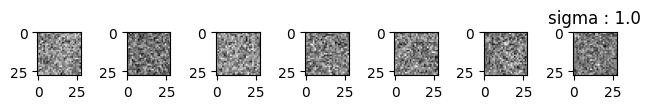

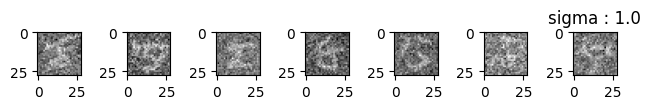

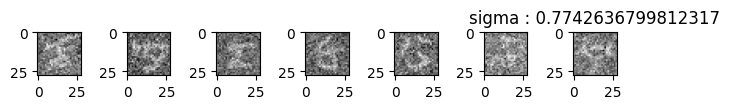

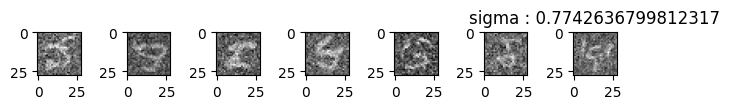

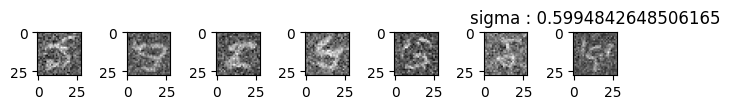

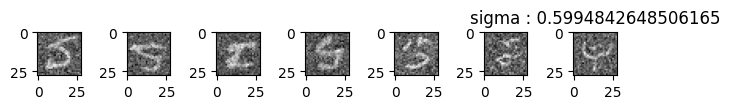

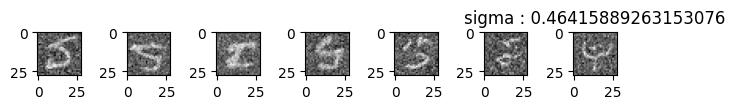

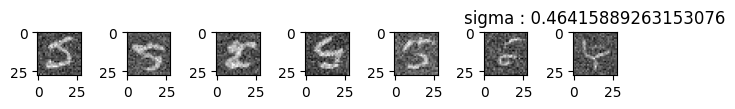

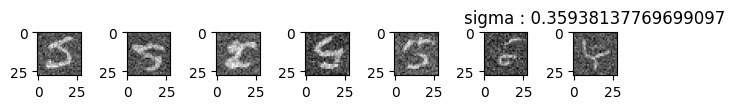

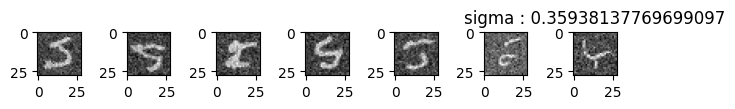

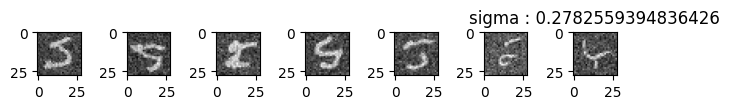

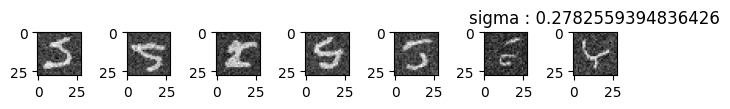

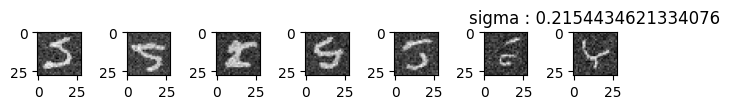

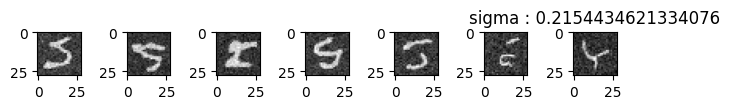

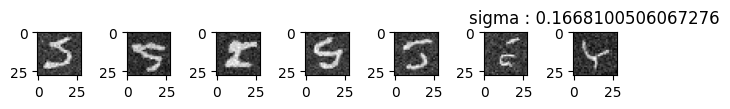

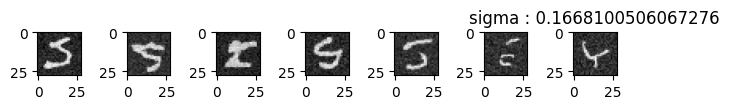

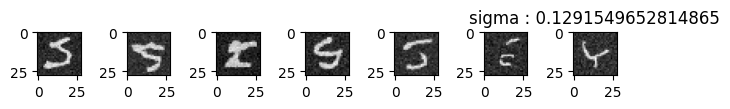

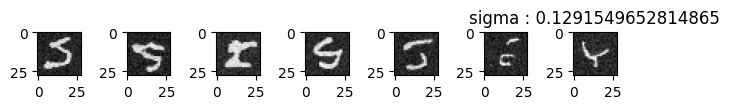

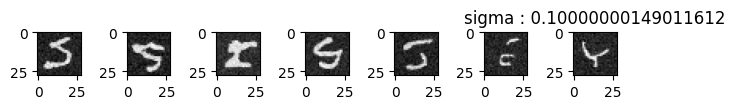

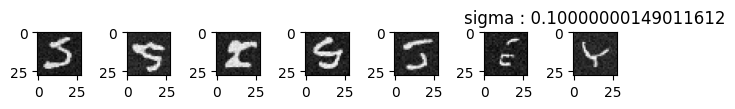

In [61]:
# ald estimated score
ALD_estimated_score_snr = annealded_langevin_sampler_snr(
    prior_normal,
    estimated_distribution_scores,
    sigmas,
    0.04,
    SCORE_NORM,
    T = 50,
    n_chain=7
)



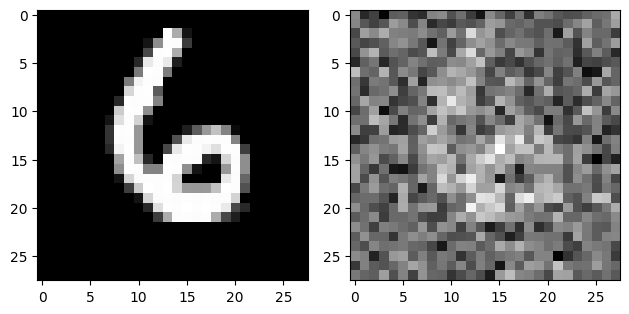

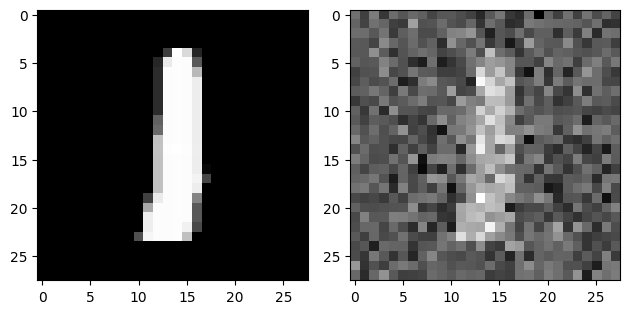

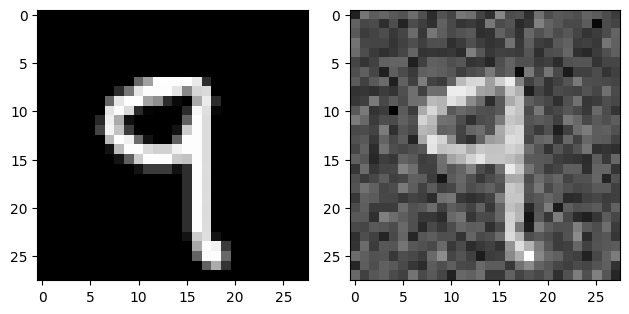

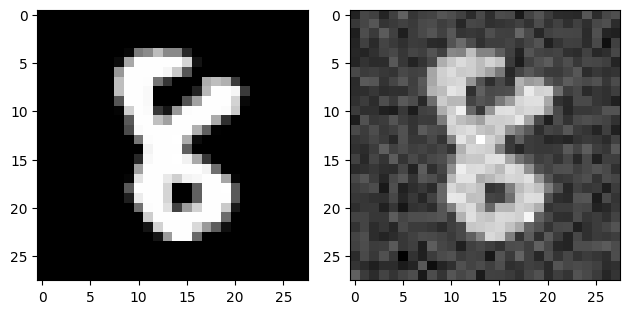

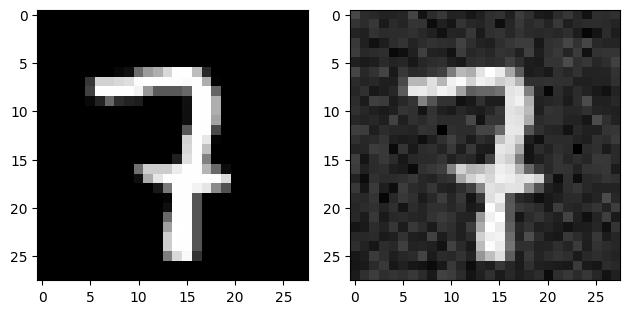

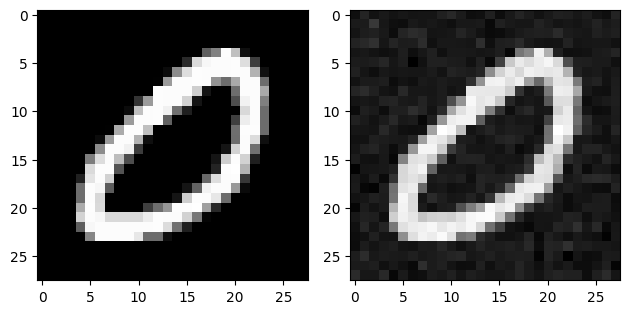

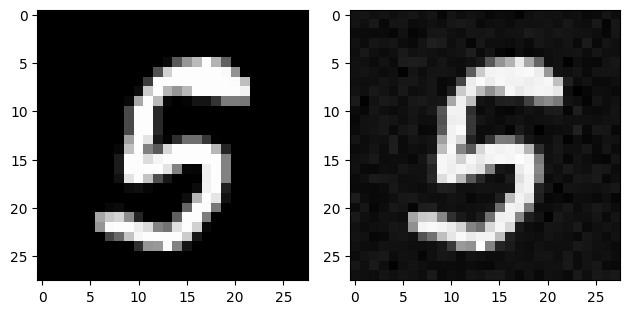

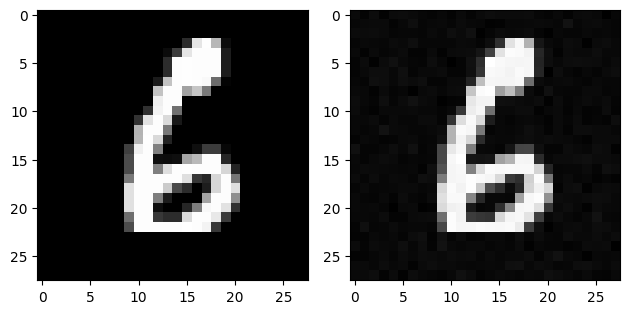

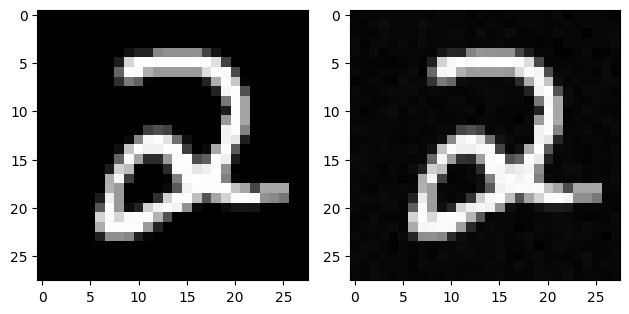

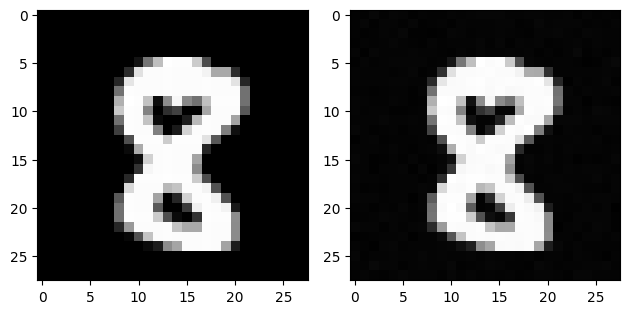

In [50]:
## voir un éleéments de chaque distribution : 
for idx in range(N_SIGMAS):
    x_ref,_ = next(iter(dataloader))

    s = sigmas[idx]    
    x_ref = x_ref[0].to(device)
    x_noisy = x_ref + torch.randn_like(x_ref) * s
    plt.subplot(1,2,1)
    plt.imshow(x_ref.squeeze().cpu(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(x_noisy.squeeze().cpu(),cmap= 'gray',label = 'noisy | noise = {s}')
    plt.tight_layout()
    plt.show()

In [53]:
def annealded_langevin_sampler_snr_pc(
    prior,
    noisy_distrib_scores,   # liste de réseaux: score(x, sigma_i)
    noise_factor,           # liste de sigmas: sigma_i (du +bruité -> -bruité)
    SNR,                    # SNR en puissance (comme tu l'as défini)
    norm,                   # liste: E[||score||^2] pour chaque sigma_i
    T_corrector,            # nb de steps de Langevin (corrector) par niveau
    n_chain,
    save_dir=None,
):
    C, H, W = 1, 28, 28
    X = prior.sample((n_chain, C, H, W)).to(device)

    D = H * W  # dim par image (pour approx ||z||^2 ≈ D)

    if save_dir is not None:
        if os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        os.makedirs(save_dir)

    frame = 0

    N = len(noisy_distrib_scores)

    # --- boucle des niveaux de bruit (VE) ---
    for i in range(N):

        sigma_i = noise_factor[i]

        # =========================
        # 1) PREDICTOR (reverse diffusion VE)
        # =========================
        # pour VE: x_{i-1} = x_i + (σ_i^2 - σ_{i+1}^2) * s(x_i, σ_i) + sqrt(σ_i^2 - σ_{i+1}^2) * z
        # ici on va de i -> i+1 (ou on considère que noise_factor est déjà ordonné dans le bon sens)
        # donc on ne fait le predictor que si on n'est pas au dernier niveau
        if i < N - 1:
            sigma_next = noise_factor[i + 1]
            delta_sigma2 = sigma_i**2 - sigma_next**2

            # si jamais les sigmas ne sont pas triés comme prévu
            if delta_sigma2 < 0:
                # on inverse (au pire) pour éviter NaN, mais mieux vaut avoir sigma_i >= sigma_next
                delta_sigma2 = abs(delta_sigma2)

            z_pred = torch.randn_like(X)
            # reverse diffusion predictor step
            X = X + delta_sigma2 * noisy_distrib_scores[i](X) + math.sqrt(delta_sigma2) * z_pred

        # =========================
        # 2) CORRECTOR (Langevin avec SNR puissance)
        # =========================
        # SNR_power = R = epsilon * ||score||^2 / (2 ||z||^2)
        # en approx: ||z||^2 ≈ D, ||score||^2 ≈ norm[i]
        # => tau = epsilon ≈ 2 * R * D / norm[i]
        tau = 2.0 * D * SNR / norm[i]
        noise_std = math.sqrt(2.0 * tau)

        for step in range(T_corrector):
            score = noisy_distrib_scores[i](X)
            X = X + tau * score + noise_std * torch.randn_like(X)

            # visualisation début / fin du niveau
            if step == 0 or (step + 1) % T_corrector == 0:
                plt.figure(figsize=(12, 2))
                for u in range(min(X.shape[0], 8)):
                    plt.subplot(1, min(X.shape[0], 8), u + 1)
                    plt.imshow(X[u].clone().squeeze().cpu(), cmap='gray')
                    plt.axis('off')
                plt.suptitle(f'sigma : {sigma_i:.5f}')
                plt.tight_layout()

                if save_dir is not None:
                    fname = f"pc_sigma_{i:03d}_step_{step:04d}.png"
                    plt.savefig(os.path.join(save_dir, fname), dpi=200)
                plt.show()
                frame += 1

    return X


In [50]:
sigmas

tensor([1.0000, 0.7743, 0.5995, 0.4642, 0.3594, 0.2783, 0.2154, 0.1668, 0.1292,
        0.1000], device='cuda:0')

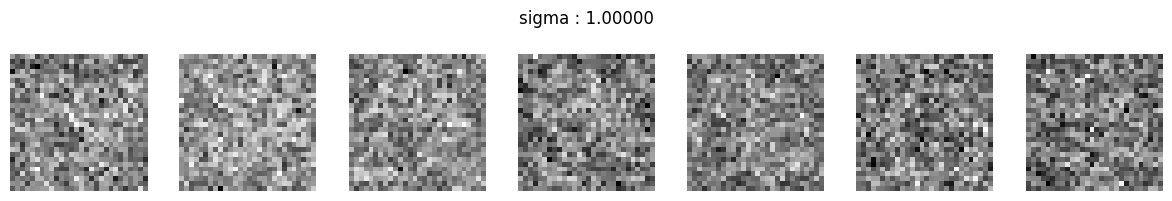

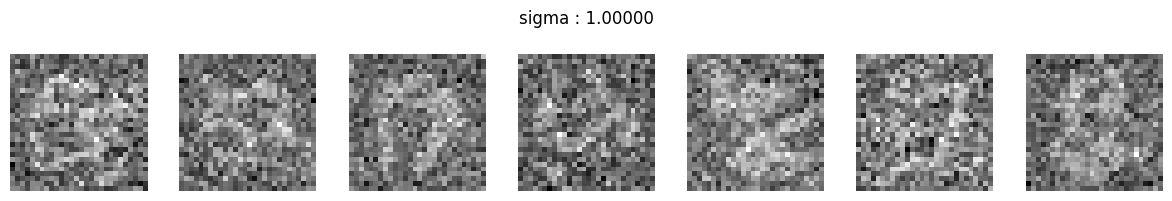

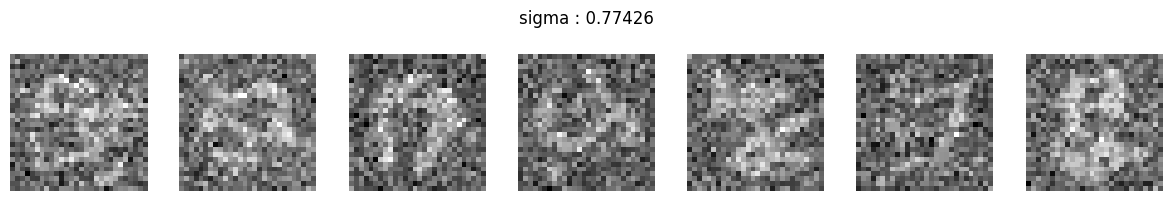

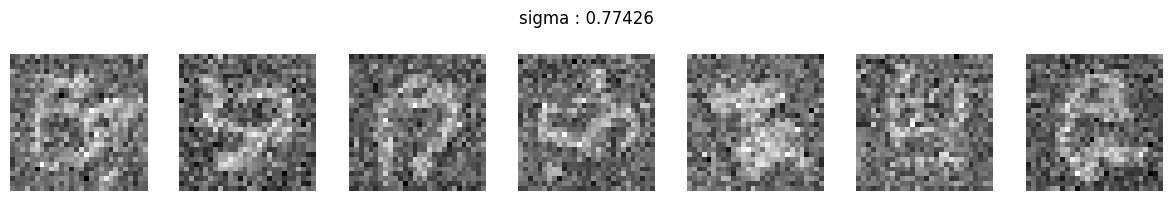

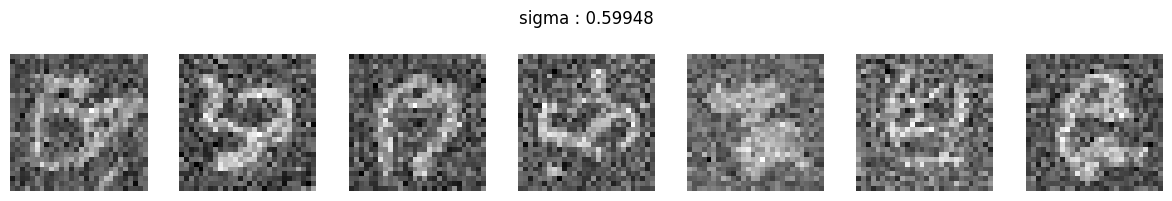

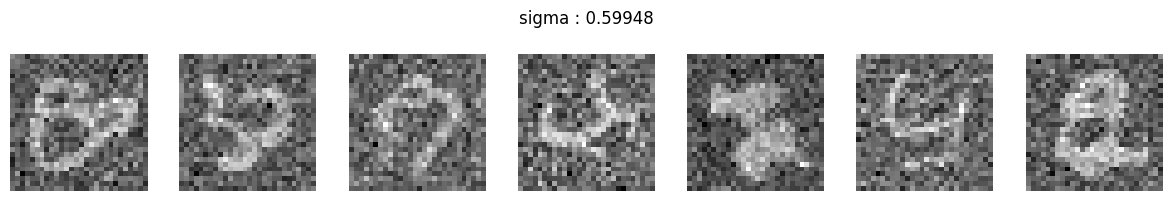

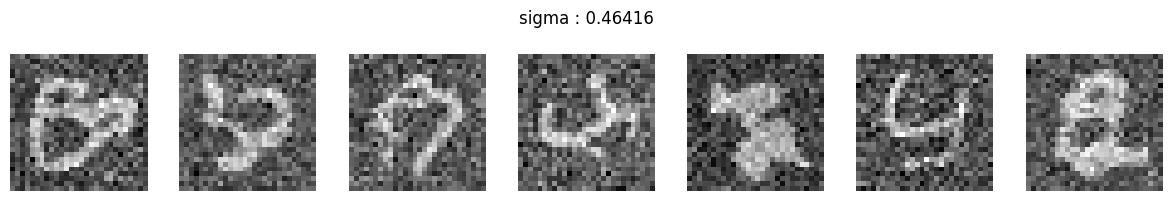

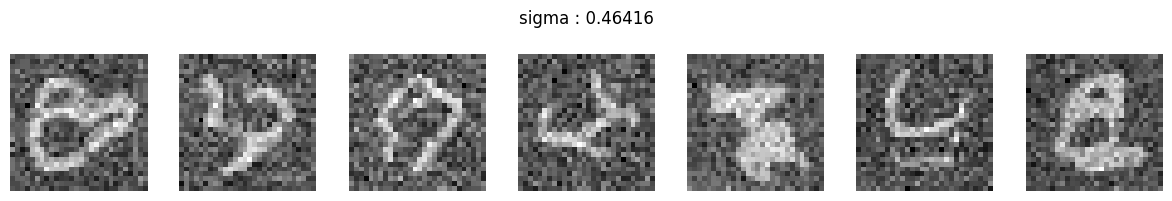

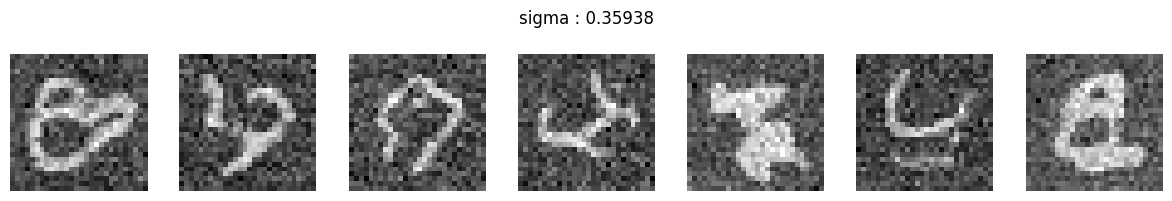

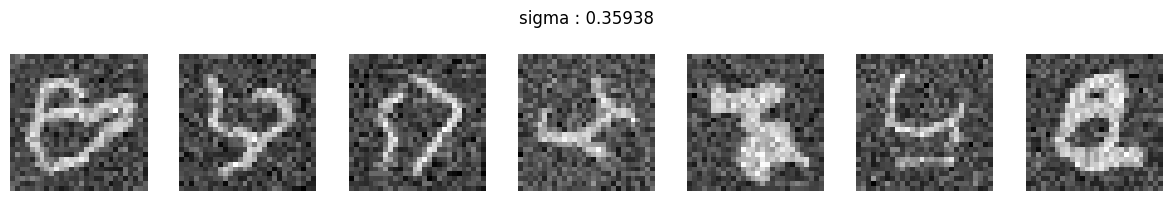

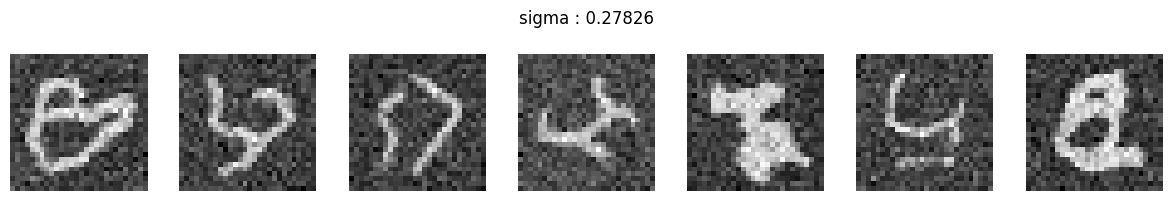

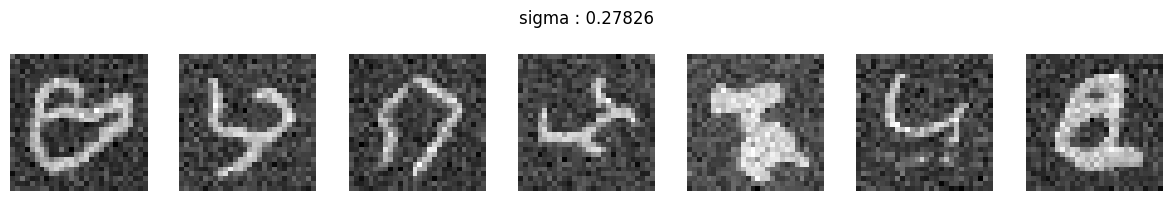

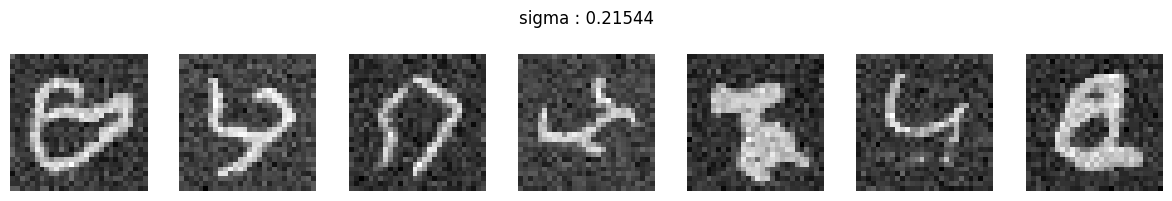

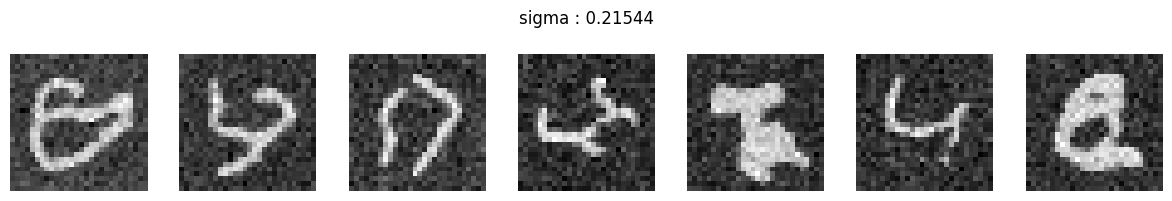

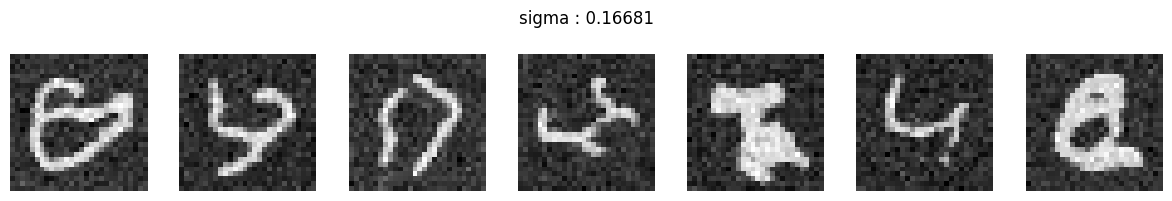

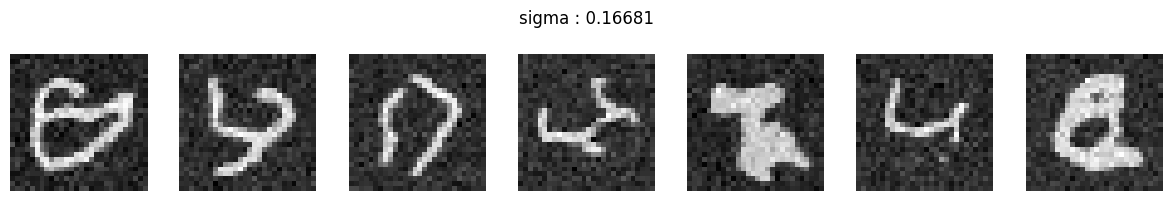

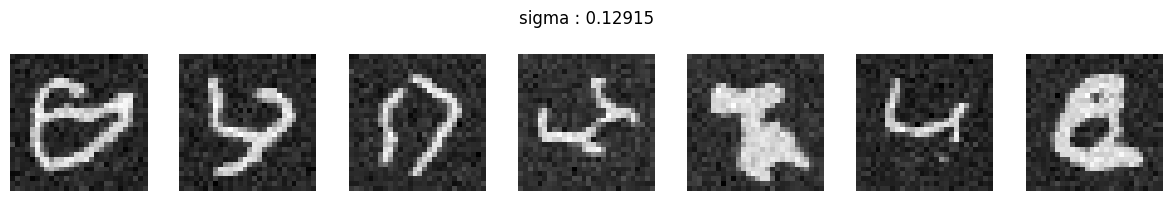

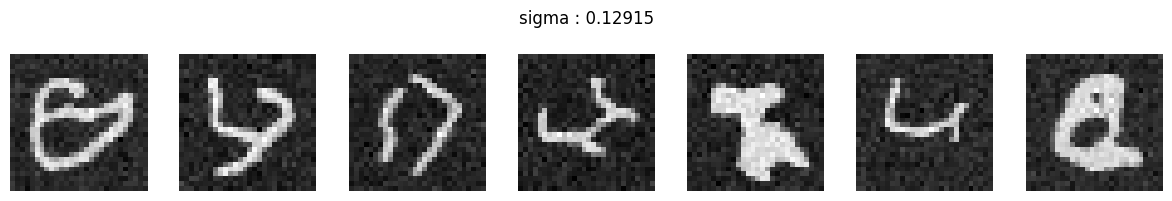

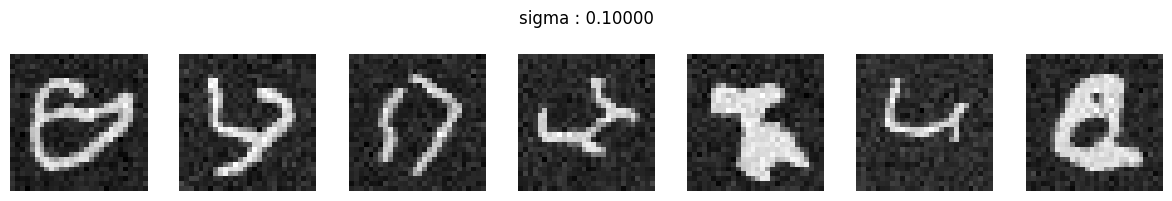

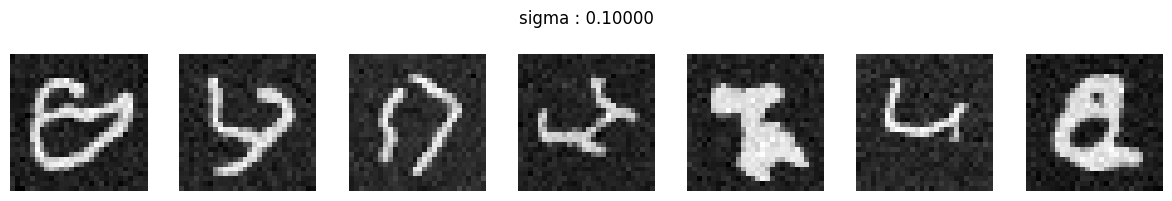

In [67]:
# ald estimated score
ALD_estimated_score_snr = annealded_langevin_sampler_snr_pc(
    prior_normal,
    estimated_distribution_scores,
    sigmas,
    0.03,
    SCORE_NORM,
    T_corrector = 40,
    n_chain=7
)

